# Autoencoder based Anomaly Detection
https://dacon.io/competitions/official/235757/codeshare/4641?page=1&dtype=recent

본 코드는 오토인코더 기반의 이상탐지 모델을 활용하였습니다.

Conv1D-LSTM 기반의 Autoencoder 모델을 구현하였으며 구현 시 라이브러리는 tensorflow의 keras를 이용했습니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

위의 라이브러리를 활용하였습니다.

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,matplotlib,pandas,sklearn,tqdm,TaPR_pkg,pathlib,tensorflow

CPython 3.6.11
IPython 7.16.1

numpy 1.18.5
matplotlib 3.3.1
pandas 1.1.2
sklearn 0.0
tqdm 4.48.2
TaPR_pkg unknown
pathlib 1.0.1
tensorflow 2.3.0


위와 같이 tensorflow 버전은 2.0 이상의 버전을 활용하였습니다.

TaPR 패키지는 baseline을 참고해주시면 됩니다.

본 코드에서는 "eTaPR-1.12-py3-none-any.whl" 파일을 직접 설치하였습니다.

"eTaPR-1.12-py3-none-any.whl"이 존재하는 경로에서
python -m pip install "eTaPR-1.12-py3-none-any.whl"와 같은 명령어를 실행하시면 쉽게 설치할 수 잇습니다.

## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

데이터 전처리 및 데이터를 불러오는 방법의 대부분은 baseline의 코드를 참고하였습니다.

# 1) 데이터 불러오기

In [ ]:
TRAIN_DATASET = sorted([x for x in Path("D:\\data\\HAI 2.0\\training\\").glob("*.csv")])
TRAIN_DATASET

In [ ]:
TEST_DATASET = sorted([x for x in Path("D:\\data\\HAI 2.0\\testing").glob("*.csv")])
TEST_DATASET

In [ ]:
VALIDATION_DATASET = sorted([x for x in Path("D:\\data\\HAI 2.0\\validation").glob("*.csv")])
VALIDATION_DATASET

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


# 2) 변수 설정

그 다음은 baseline과 동일하게 필드명을 활용하였습니다.

<baselin 참조>

학습 데이터셋은 공격을 받지 않은 평상시 데이터이고 시간을 나타내는 필드인 time이 있으며, 나머지 필드는 모두 비식별화된 센서/액추에이터의 값입니다. 정규화는 센서/액추에이터 필드만을 대상으로 해야 합니다.

본 문서에서는 전체 데이터를 대상으로 이상을 탐지하므로 "attack" 필드만 사용하였습니다.

VALID_COLUMNS_IN_TRAIN_DATASET은 학습 데이터셋에 있는 모든 센서/액추에이터 필드를 담고 있습니다. 가끔 학습 데이터셋에 존재하지 않는 필드가 테스트 데이터셋에 존재하는 경우가 있습니다. 학습 시 보지 못했던 필드에 대해서 테스트를 할 수 없으므로 학습 데이터셋을 기준으로 필드 이름을 얻어냈습니다.

In [ ]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

# 3) 데이터 정규화

본 연구에서도 normalize 함수를 통해 데이터를 정규화 합니다.
정규화 방법은 min_max 정규화로 최댓값과 최솟값을 이용하여 0~1의 범위에 들어오도록 하였습니다.

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

먼저 train data set을 정규화 하고 boundary_check 함수를 통해 정규화가 잘 되었는지 점검합니다.

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    print(x)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
boundary_check(TRAIN_DF)

[[0.37895253 0.         0.         ... 0.2650172  1.         0.5672542 ]
 [0.37845883 0.         0.         ... 0.2504694  1.         0.5066231 ]
 [0.37845883 0.         0.         ... 0.25502798 1.         0.46494597]
 ...
 [0.30434805 0.         0.         ... 0.23551878 0.26161984 0.625875  ]
 [0.3068182  0.         0.         ... 0.26957628 0.26161984 0.6820907 ]
 [0.30484188 0.         0.         ... 0.29337597 0.26161984 0.7588398 ]]


(False, False, False)

# 학습 모델 설정

모델 구현 라이브러리는 keras를 사용하였습니다.

본 챌린지의 핵심은 정상 상황의 데이터만을 학습하여 공격 및 비정상 상황을 탐지하는 것입니다.

Autoencoder의 경우 보통 이미지의 생성이나 복원에 많이 사용되며, 정상적인 이미지로 모델 학습 후 비정상적인 이미지를 넣어 이를 디코딩 하게 되면 정상 이미지 특성과 디코딩 된 이미지 간의 차이인 재구성 손실(Reconstruction Error)를 계산하게 됩니다. 이 재구성 손실이 낮은 부분은 정상(normal), 재구성 손실이 높은 부분은 이상(Abnormal)로 판단할 수 있습니다.

본 연구에서는 이러한 Anomaly Detection 방법을 이미지가 아닌 시계열 데이터에 적용하였습니다.

Autoencoder의 레이어를 LSTM으로 구성하여 시퀸스 학습이 가능하게 하였습니다.
또한, !D-Convolution layer를 적용하여 timestamp와 feature 정보를 세밀하게 이동하면서 학습이 진행되도록 하였습니다.

In [ ]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

위의 함수를 통해서 데이터 셋 자체를 timestamp로 나누어서 학습을 진행할 수 있지만,
Conv1D 레이어를 활용하였기 때문에 timestamp는 1로 두고 3 차원의 shpae 형태로 만들어 주었습니다.

In [ ]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(921603, 1, 79)

# 학습 모델의 구조

파라미터 설명

Conv1D
- filters : 컨볼루션 연산의 output 출력 수
- kernel_size : timestamp를 얼마만큼 볼 것인가(=window_size)
- padding : 한 쪽 방향으로 얼마만큼 padding할 것인가
- dilation: kernel 내부에서 얼마만큼의 간격으로 kernel을 적용할 것인가
- stride: default = 1, 컨볼루션 레이어의 이동크기

LSTM
- unit: 출력 차원층만 설정

모델의 구조는 Conv1D - Dense층 - LSTM - Dense층으로 encoder 와 decoder가 대칭이 되도록 설계하였습니다.
파라미터는 주로 filters, kernel_size, Dense, LSTM의 units 값을 조절하면서 실험을 진행하였습니다.
파라미터 값을 수정하면서 많은 실험을 진행하였지만 다음과 같은 모델의 결과가 가장 좋았습니다.

추가적으로 Conv1D 레이어를 추가하거나 maxpooling과 같이 기존의 CNN 모델과 동일한 방식을 적용할 수 있습니다.

제가 실험을 할 때는 pooling을 적용하지 않는 것이 결과가 좋았지만 모델을 테스트 해보실 분들은 다양하게 
레이어와 파라미터 값을 조절 하면서 해보시면 좋을 것 같습니다.

In [ ]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

# 모델 구조 확인

In [ ]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 512)            2589184   
_________________________________________________________________
dense (Dense)                (None, 1, 128)            65664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             3

# 모델 학습하기
epoch을 50으로 하고, earlystopping을 사용하였습니다.
제출 코드에서는 예시로 에폭을 3회만 실시 하였습니다.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 3
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[early_stopping]).history

model.save('model.h5')

Train on 737282 samples, validate on 184321 samples
Epoch 1/3
737282/737282 [==============================] - 401s 544us/sample - loss: 0.0020 - val_loss: 3.2852e-04
Epoch 2/3
737282/737282 [==============================] - 401s 544us/sample - loss: 1.4245e-04 - val_loss: 3.2397e-04
Epoch 3/3
737282/737282 [==============================] - 390s 529us/sample - loss: 8.5787e-05 - val_loss: 2.5324e-04


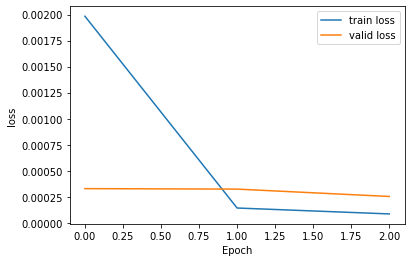

In [ ]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# 학습된 모델 불러오기

기존의 학습된 모델 중 가장 결과가 좋았던 모델을 불러와서 결과를 확인해보도록 하겠습니다.

In [ ]:
model = load_model('best_model.h5')

# 학습된 모델을 검증 데이터셋에 적용하여 이상 탐지

In [ ]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


검증 데이터 셋에서는 정상 데이터를 기준으로 정규화를 진행합니다.
그리고, 최솟값과 최댓값을 넘어가는 것이 있는지 확인합니다.

In [ ]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
boundary_check(VALIDATION_DF)

[[0.45158097 0.         0.         ... 0.5797802  0.52712005 0.4013713 ]
 [0.45256948 0.         0.         ... 0.5799144  0.52712005 0.32340166]
 [0.45207536 0.         0.         ... 0.5926521  0.52712005 0.37272498]
 ...
 [0.39772758 0.         0.         ... 0.6184636  0.17970447 0.23875508]
 [0.3997038  0.         0.         ... 0.62228477 0.17970447 0.129734  ]
 [0.401186   0.         0.         ... 0.62047464 0.17970447 0.02301037]]


(True, True, False)

그래프로 시각화를 하여 보았을 때도 일정 구간에서 0과 1 범위를 벗어나는 것을 확인할 수 있습니다.

<AxesSubplot:>

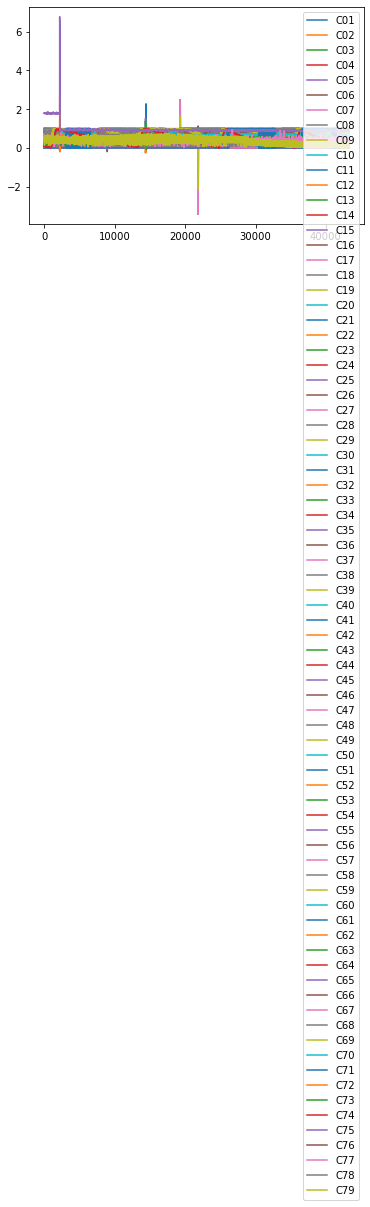

In [ ]:
VALIDATION_DF.plot()

<AxesSubplot:>

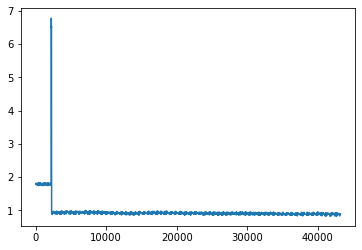

In [ ]:
VALIDATION_DF['C75'].plot()

# Data cleaning
모델을 실험하면서 최종결과를 확인할 때 복원이 잘 되는 것을 확인할 수 있었지만,
앞부분의 정상구간이 다른 정상구간 보다 Reconstruction_error가 높게 나타나는 것을 알 수 있었습니다.

그래서 확인을 했을 때 한 변수가 정상인 구간에서 1이 넘어가는 값을 가지고 있었습니다.

validation set에서 조금 더 정교하게 threshold 조절 및 결과를 확인하기 위해서 해당 변수의 값을 정상 범위에 맞게 임의로 조절하였습니다.

하지만 이부분은 특이한 경우로 validation에서는 정답 label 값을 알고 있고, 정상이지만 비정상 구간에서 일정하게 나타나고 있었기 때문에 조절하였습니다.

In [ ]:
# valid 그래프를 보고 앞부분 정상인데 값이 튀는 변수가 있어서 조절
VALIDATION_DF['C75'][:2110] = 0.95

In [ ]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(43201, 1, 79)

모델의 결과가 3차원의 형태이기 때문에 복원된 결과와의 차이를 확인하기 위해서는 2차원으로 다시 바꿔줘야합니다.

그래서 flatten 함수를 구현하여 활용하였습니다.

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

모델의 의해 재구성된 값을 실제 값과 차이를 구해서 재구성 손실(reconstruction error) 값을 구해줍니다.

정상인경우 모델이 잘 학습되어 복원이 잘 되었기 때문에 reconstruction error 값이 작게 나올 것이고,
공격인 경우 정규화된 값에서 0과 1을 벗어나기 때문에 reconstruction error 값이 크게 나올 것입니다.

In [ ]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

(43201, 1, 79)
(43201, 79)
(43201,)
7.681452989578247


# Precision Recall Curve

threshold의 경우 Recall과 Precision의 값이 교차되는 지점을 기준으로 조금 씩 수정하면서 결과를 확인하였습니다.

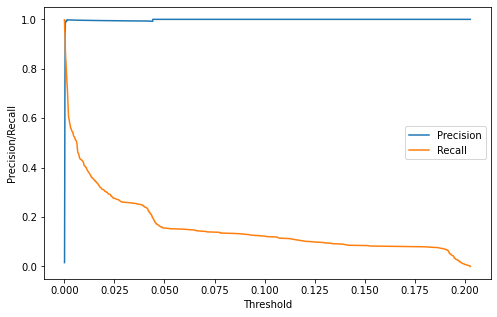

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()

In [ ]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.9411764705882353 , recall:  0.9411764705882353
threshold:  0.00036586847637974846


위에서 data cleaning을 적용하였을 때 precision 및 recall 값도 높게 잘 나오는 것을 확인할 수 있었습니다.

# Predict Validation data set
우선 위에서 구한 threshold의 값으로 시각화를 하여 결과를 확인해 보겠습니다.

Text(0.5, 0, 'Data point index')

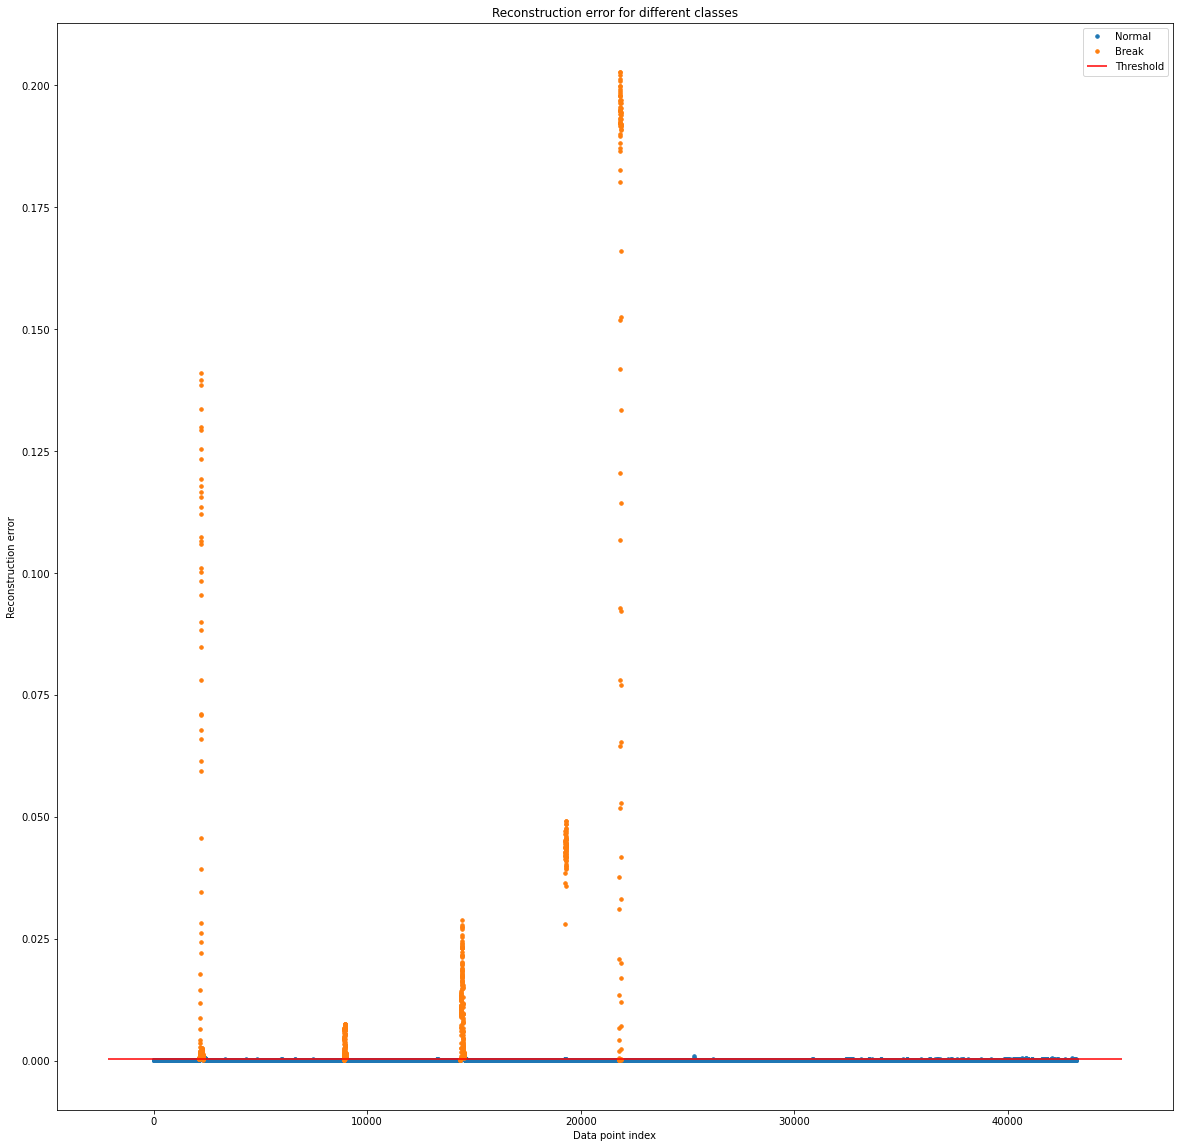

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

결과를 확인해보면 정상인 구간에서는 복원이 잘 되어 reconstruction error 값이 작게 나왔고, 비정상인 구간은 확실하게 reconstruction error 값이 높게 나오는 것을 확인할 수 있습니다.

# 이동평균 

그 다음 조금 더 좋은 결과를 얻기 위해서 이동평균 값을 활용하였습니다.

reconstruction error의 이동 평균 값을 활용함으로써 정상인 구간과 비정상인 구간을 조금 더 명확하게 구분할 수 있었습니다.

threshold 값을 기준으로 구분하다보면 시작점과 끝점을 찾는 것이 어려웠습니다.
그래서 이동평균 값을 통해 정상인 구간은 평균적으로 더 낮게 하고, 비정상인 구간은 평균적으로 더 높은 값을 나타내도록 하였습니다.

In [ ]:
#이동평균
mean_window = error_df['Reconstruction_error'].rolling(50).mean()
window_error = mean_window.fillna(0)
window_error

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
43196    0.000138
43197    0.000138
43198    0.000137
43199    0.000135
43200    0.000133
Name: Reconstruction_error, Length: 43201, dtype: float64

Text(0.5, 0, 'Data point index')

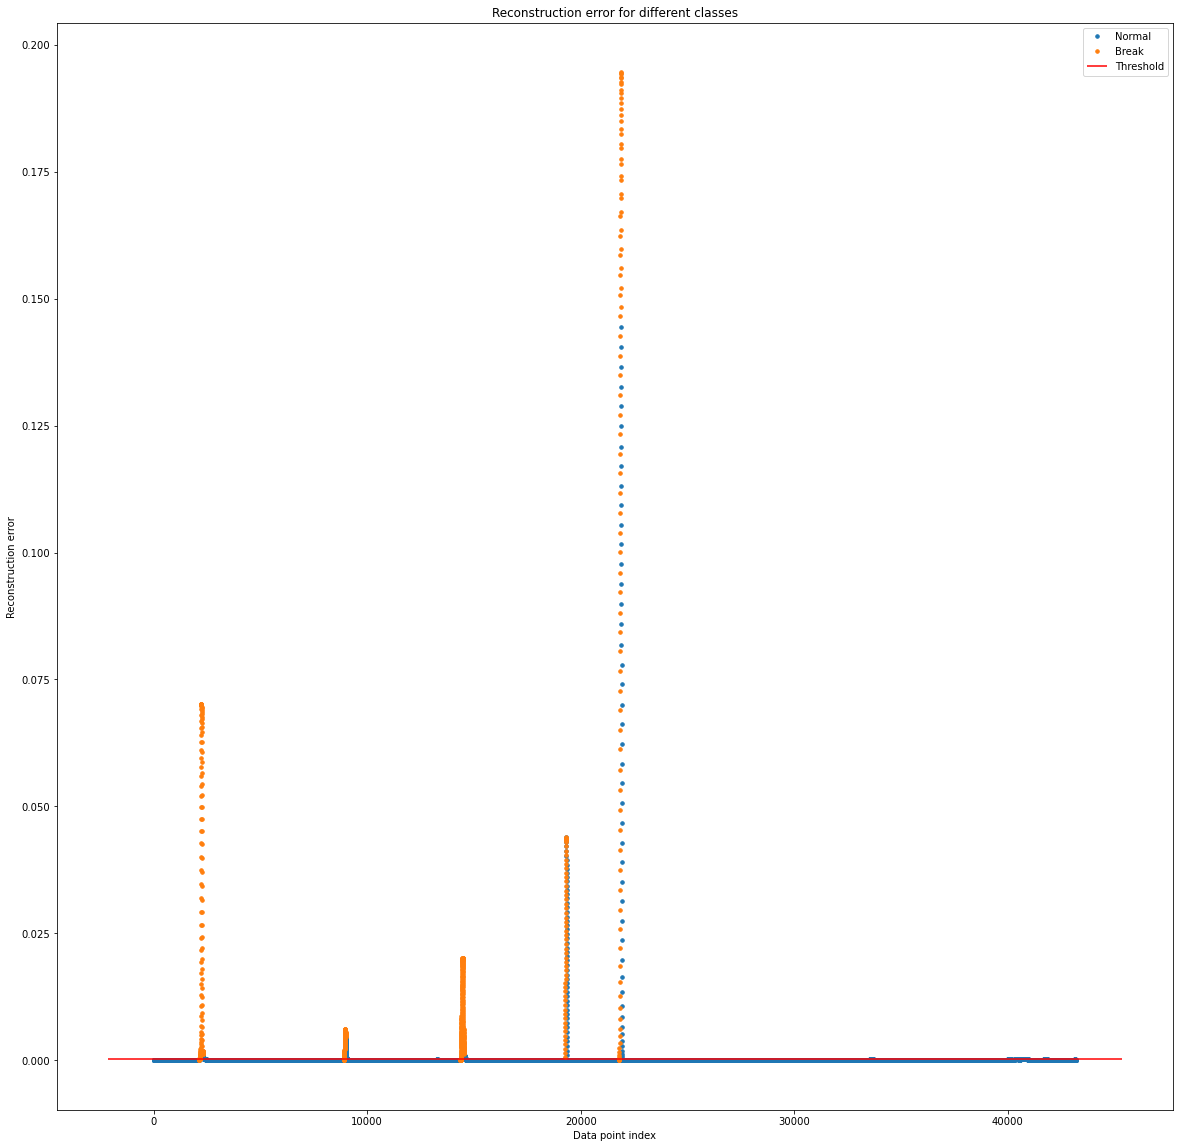

In [ ]:
window_error_df = pd.DataFrame({'Reconstruction_error': window_error ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = window_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

그 결과 공격 범위가 조금 넘어 가더라도 확실하게 공격인 구간을 잘 잡아내도록 하였습니다.

위에서 구한 threshold 값으로 validation set 의 결과를 확인해보겠습니다.

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in window_error_df['Reconstruction_error'].values]
pred_y = np.array(pred_y)
pred_y.shape

(43201,)

# 평가

In [ ]:
ATTACK_LABELS = np.array(VALIDATION_DF_RAW[ATTACK_FIELD])
FINAL_LABELS = np.array(pred_y)

ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [ ]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.998 (TaP: 0.998, TaR: 0.997)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


비정상 구간에서 특이했던 변수의 데이터 값을 조절하고, 이동 평균 값을 활용하였을 때 validation set에서 TaPR 점수가 99.8이라는 높은 점수가 나오는 것을 확인할 수 있었습니다.

# Predict Test data set

validation data set과 동일한 방법으로 진행하였습니다.

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.0,0.0,0.073426,0.581096,0.998079,0.446527,0.680775,0.016853,0.386044,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.0,0.0,0.073426,0.639210,0.998079,0.474916,0.436791,0.015748,0.453718,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.0,0.0,0.073426,0.699587,0.998079,0.475741,0.598077,0.015116,0.563381,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


test dataset에서는 validation dataset에서 처럼 특이한 경우가 보이지 않아서 데이터 값을 정규화만 하고, 그대로 진행하였습니다.

<AxesSubplot:>

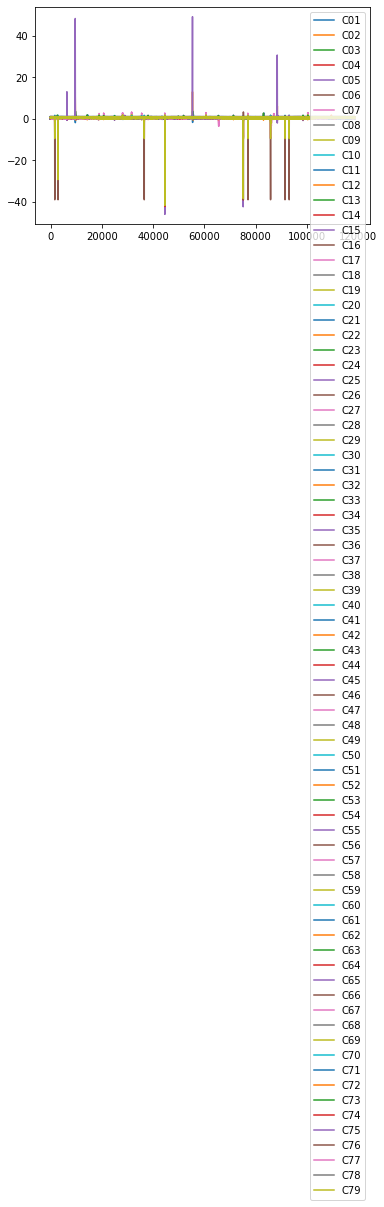

In [ ]:
TEST_DF.plot()

In [ ]:
boundary_check(TEST_DF)

[[0.27371535 0.         0.         ... 0.20038876 0.26161984 0.7147216 ]
 [0.27371535 0.         0.         ... 0.19849946 0.26161984 0.6501059 ]
 [0.27282545 0.         0.         ... 0.19687971 0.26161984 0.64428467]
 ...
 [0.6208987  0.         0.         ... 0.48440555 0.26161984 0.666539  ]
 [0.62103254 0.         0.         ... 0.4740037  0.26161984 0.6389876 ]
 [0.62149084 0.         0.         ... 0.47706646 0.26161984 0.555689  ]]


(True, True, False)

In [ ]:
test = np.array(TEST_DF)
x_test = test.reshape(test.shape[0], 1, test.shape[1])
x_test.shape

(358804, 1, 79)

In [ ]:
start = time.time()
test_x_predictions = model.predict(x_test)
#print(test_x_predictions)
print(test_x_predictions.shape)
#print((flatten(x_test) - flatten(test_x_predictions)).shape)
test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)
print(time.time()-start)

(358804, 1, 79)
(358804,)
57.45735478401184


In [ ]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

테스트 데이터 셋에서는 label 값을 알 수 없었기 때문에, 
이동평균의 구간과 threshold 값을 조금씩 변경하면서 제출 후 결과를 보고 조절하였습니다.

In [ ]:
test_move = test_error['Reconstruction_error'].rolling(71).mean()

test_d = test_move.fillna(0)
test_d

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
358799    0.000335
358800    0.000333
358801    0.000332
358802    0.000330
358803    0.000328
Name: Reconstruction_error, Length: 358804, dtype: float64

In [ ]:
movemean_test = pd.DataFrame({'Reconstruction_error': test_d})

In [ ]:
pred_y_test = [1 if e > 0.000425 else 0 for e in movemean_test['Reconstruction_error'].values]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(358804,)

In [ ]:
submission = pd.read_csv('D:\\python_project\\hyunmin_project\\ot보안\\data\\HAI 2.0\\sample_submission.csv')
submission.index = submission['time']
submission['attack'] = pred_y_test

In [ ]:
submission['attack'].value_counts()

0    349649
1      9155
Name: attack, dtype: int64

Text(0.5, 0, 'Data point index')

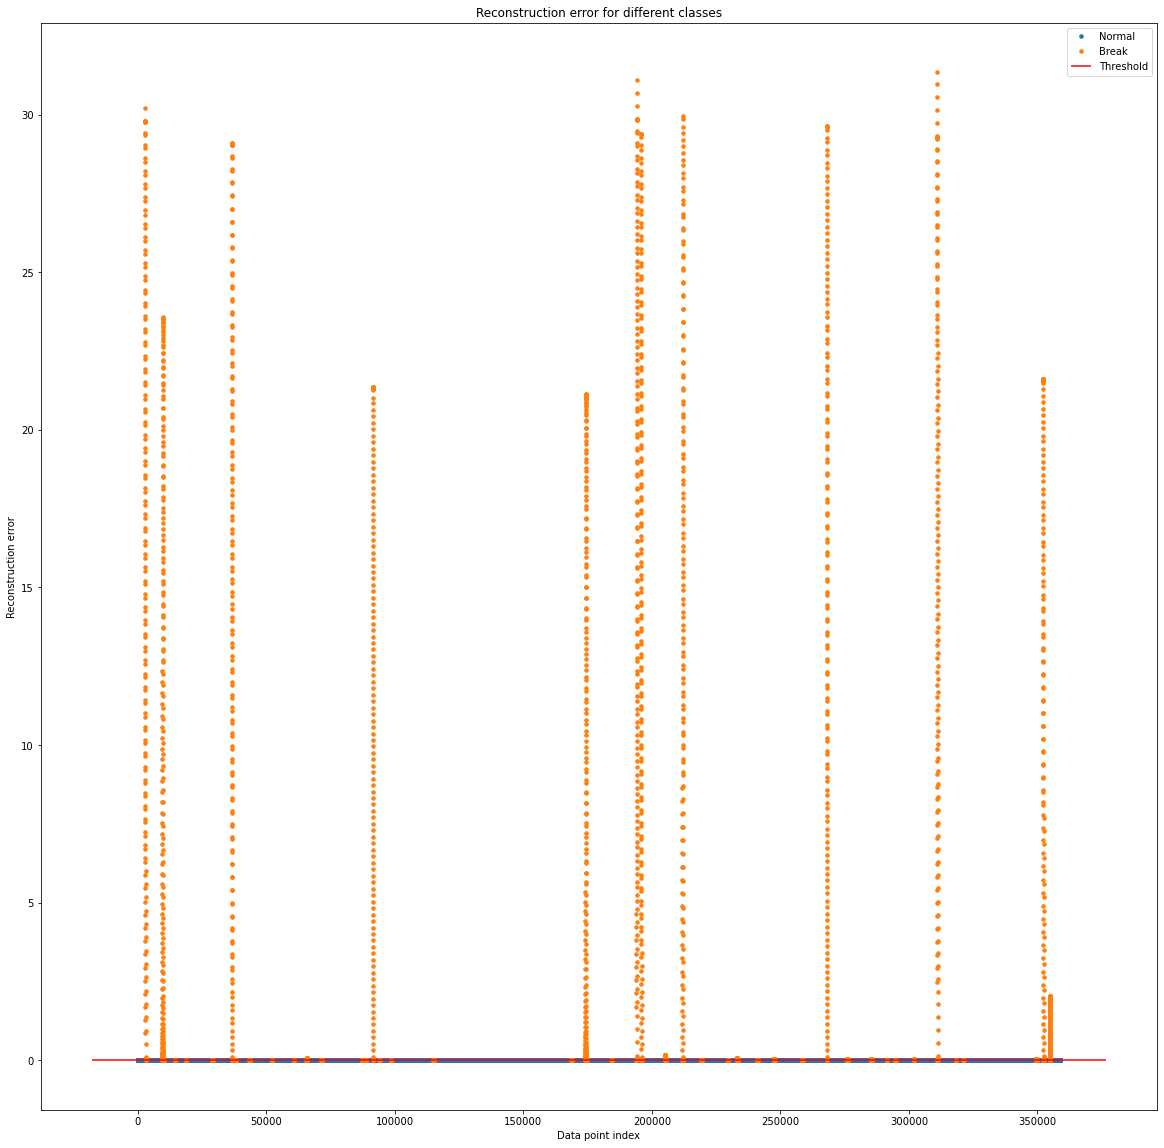

In [ ]:
test_error_df = pd.DataFrame({'Reconstruction_error': test_d,
                         'True_class': list(submission['attack'])})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(0.000425, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

최종 예측한 label의 결과를 확인해보았습니다.

마지막으로 결과를 제출약식에 맞춰 저장합니다.

In [ ]:
#submission.to_csv('predict.csv', index=False)